In [134]:
%matplotlib inline
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.cross_validation import train_test_split, KFold
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import izip
from math import exp, log
from unbalanced_dataset.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from statsmodels.discrete.discrete_model import Logit
from statsmodels.tools import add_constant
from sklearn.grid_search import GridSearchCV
from sklearn.preprocessing import scale

In [545]:
def preprocess(dropcols=['last_sign_in_at'] ,today='2016-06-20'):
    # Defining today's day for reference
    date = pd.to_datetime(today)
    
    # Loading csv extracted from database into a Pandas DataFrame
    df = pd.read_csv('dataset.csv', usecols=range(1,17))
    
    # Dropping Vango's team ids
    vango_ids = [38175, 1, 1326, 587, 736, 45651, 67966, 48516, 84261, 30975, 4260]
    for _id in vango_ids:
        df = df[df.id != _id]
    
    # Treating date fields and converting them to datetime timestamp
    df.created_at = pd.to_datetime(df['created_at'])
    df.last_session = pd.to_datetime(df['last_session'])
    df.last_favorited_artwork_date = pd.to_datetime(df['last_favorited_artwork_date'])
    df.last_followed_artist_date = pd.to_datetime(df['last_followed_artist_date'])
    
    # Creating function to extract only the days (int) from TimeDelta objects
    def extract_days(x):
        try:
            return x.days
        except:
            return 0
    
    # New feature: Extracting the difference between last session and today
    df['days_from_last_session'] = date - df.last_session
    df['days_from_last_session'] = df.days_from_last_session.apply(lambda x: extract_days(x))

    # New feature: Extracting the difference between last session and when user registered
    df['diff_created_to_last'] = df.last_session - df.created_at
    df['diff_created_to_last'] = df.diff_created_to_last.apply(lambda x: extract_days(x))

    # New feature: Extracting the difference between last favorited artwork and today
    df['diff_last_fav_artwork_to_today'] = date - df.last_favorited_artwork_date
    df['diff_last_fav_artwork_to_today'] = df.diff_last_fav_artwork_to_today.apply(lambda x: extract_days(x))

    # New feature: Extracting the difference between last artists followed and today
    df['diff_last_artist_folw_to_today'] = date - df.last_followed_artist_date
    df['diff_last_artist_folw_to_today'] = df.diff_last_artist_folw_to_today.apply(lambda x: extract_days(x))
    
    df = df.set_index('id')

    # Dropping columns
    df = df.drop(drop_cols, axis=1)
    
    # Filling NaN values with unknown for categorical variables before dummifying
    df.gender.fillna('unknown', inplace=True)
    df.user_type.fillna('unknown', inplace=True)
    df.os.fillna('unknown', inplace=True)

    # Dropping about 100 recent user ids missing all information
    df.num_sessions.dropna(inplace=True)

    # Dropping 3 records based on gender feature
    df = df[(df.gender != 'male (hidden)') & (df.gender != 'female (hidden)')]
    
    # Dummifying categorical variables (gender, user_type, and os)
    df = pd.concat([df, pd.get_dummies(df.gender, prefix='gender', drop_first=True)], axis=1)
    df = df.drop('gender', axis=1)

#     df = pd.concat([df, pd.get_dummies(df.user_type, prefix='user_type', drop_first=True)], axis=1)
    df = df.drop('user_type', axis=1)

#     df = pd.concat([df, pd.get_dummies(df.os, prefix='os', drop_first=True)], axis=1)
    df = df.drop('os', axis=1)

    # Finally dropping off random Na values (101 records)
    df.dropna(inplace=True)
    
    return df

def create_label(df, name='label', original_col_name='diff_created_to_last', smaller_than=200):
    df[name] = np.where(df[original_col_name] < smaller_than, 1, 0)
    
    # Dropping date columns due to high relationship and used to create the label:
    df.drop('diff_last_fav_artwork_to_today', axis=1, inplace=True)
    df.drop('diff_last_artist_folw_to_today', axis=1, inplace=True)
    df.drop('diff_created_to_last', axis=1, inplace=True)
    df.drop('days_from_last_session', axis=1, inplace=True)

In [546]:
def standard_confusion_matrix(y_true, y_predict):
    [[tn, fp], [fn, tp]] = confusion_matrix(y_true, y_predict)
    return np.array([[tp, fp], [fn, tn]])
    
    
def roc_curve(probabilities, labels):
    thresholds = np.sort(probabilities)

    tprs = []
    fprs = []

    num_positive_cases = sum(labels)
    num_negative_cases = len(labels) - num_positive_cases

    for threshold in thresholds:
        # With this threshold, give the prediction of each instance
        predicted_positive = probabilities >= threshold
        # Calculate the number of correctly predicted positive cases
        true_positives = np.sum(predicted_positive * labels)
        # Calculate the number of incorrectly predicted positive cases
        false_positives = np.sum(predicted_positive) - true_positives
        # Calculate the True Positive Rate
        tpr = true_positives / float(num_positive_cases)
        # Calculate the False Positive Rate
        fpr = false_positives / float(num_negative_cases)

        fprs.append(fpr)
        tprs.append(tpr)

    return tprs, fprs, thresholds.tolist()


def fit_logistic_regression(X, y):
    
    sm = SMOTE(kind='regular')
    X_resampled, y_resampled = sm.fit_transform(X, y)
    
    # Splitting train and test data
    X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.3)
    
    # Fitting regression and getting its scores
    log_reg = LogisticRegression()
    log_reg.fit(X_train, y_train)
    predict_log = log_reg.predict(X_test)
    print "\nLogistic Regression Scores:\n"
    print "Accuracy on test set:", log_reg.score(X_test, y_test)
    print "Precision:", precision_score(y_test, predict_log)
    print "Recall:", recall_score(y_test, predict_log)
    
    # Fitting multiple k-fold cross validations and getting mean scores
    kfold = KFold(len(y))

    accuracies = []
    precisions = []
    recalls = []

    for train_index, test_index in kfold:
        model = LogisticRegression()
        model.fit(X[train_index], y[train_index])
        y_predict = model.predict(X[test_index])
        y_true = y[test_index]
        accuracies.append(accuracy_score(y_true, y_predict))
        precisions.append(precision_score(y_true, y_predict))
        recalls.append(recall_score(y_true, y_predict))

    print "\nK-Fold Cross Validation on Logistic Regression Scores:\n"
    print "accuracy:", np.average(accuracies)
    print "precision:", np.average(precisions)
    print "recall:", np.average(recalls)
    
    cols = list(df.columns)
    
    print
    print "Beta scores:"
    for name, coef in izip(df.columns, model.coef_[0]):
        print "%s: %.4f" % (name, coef)
    
    y_predict = log_reg.predict(X_test)
    y_proba = log_reg.predict_proba(X_test)
    cm = standard_confusion_matrix(y_test, y_predict)

    tpr, fpr, thres = roc_curve(y_proba[:,0:1].flatten(), y_test)
    plt.plot(tpr, fpr)
    plt.show()
    
    fix, ax = plt.subplots(figsize=(10, 7))
    sns.heatmap(cm, annot=True,  fmt='', square=True, \
                            xticklabels=['1', '0'], \
                            yticklabels=['1', '0']);
    
    print
    print "Likelihoods:"
    for i, coef in enumerate(log_reg.coef_[0]):
#         print "beta %s: %.5f" % (cols[i], exp(coef))
        if coef <0:
            print "*Increasing the %s by 1 point decreases the chance of label=1 by a factor of %.4f.*" % (cols[i], exp(coef))
        else:
            print "*Increasing the %s by 1 point increases the chance of label=1 by a factor of %.4f.*" % (cols[i], exp(coef))
        print
        
    print "To double:"
    for i, coef in enumerate(model.coef_[0]):
#     print "beta %s: %.5f" % (cols[i], log(2) / coef)
        if coef < 0:
            print "*Decreasing the %s score by %d points doubles the chance of label=1.*" % (cols[i], log(2) / coef)
        else:
            print "*Increasing the %s score by %d points doubles the chance of label=1.*" % (cols[i], log(2) / coef)
        print

## Model 1: Logistic Regression with Label = activity in last 200 days

In [130]:
drop_cols = ['last_sign_in_at', 
             'created_at', 
             'last_session', 
             'last_favorited_artwork_date', 
             'last_followed_artist_date',
             'total_follows',
             'total_favorites',
             'city']
df = preprocess(drop_cols)

create_label(df, name='engagement200', original_col_name='diff_created_to_last', smaller_than=200)

# Defining y label and X matrix
y = df.pop('engagement200').values
X = df.values

Determining classes statistics... 2 classes detected: Counter({1: 48224, 0: 9593})
Finding the 5 nearest neighbours...
done!
Creating synthetic samples...Generated 38631 new samples ...
done!

Logistic Regression Scores:

Accuracy on test set: 0.676308968377
Precision: 0.641019751952
Recall: 0.781902227203

K-Fold Cross Validation on Logistic Regression Scores:

accuracy: 0.837955342251
precision: 0.846670506015
recall: 0.984896691247

Beta scores:
num_sessions: -0.0232
total_artists_followed: -0.0455
total_artworks_favorited: -0.0119
total_artworks_shared: 0.0454
gender_male: -0.0694
gender_unknown: -0.7078


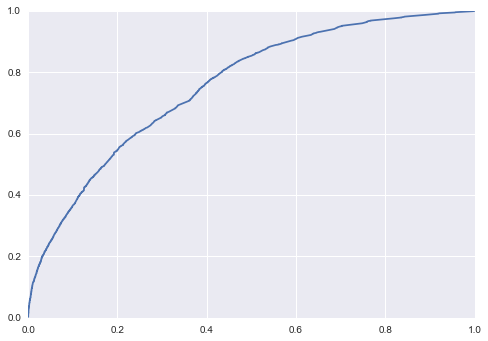


Likelihoods:
*Increasing the num_sessions by 1 point decreases the chance of label=1 by a factor of 0.9704.*

*Increasing the total_artists_followed by 1 point decreases the chance of label=1 by a factor of 0.9698.*

*Increasing the total_artworks_favorited by 1 point decreases the chance of label=1 by a factor of 0.9822.*

*Increasing the total_artworks_shared by 1 point increases the chance of label=1 by a factor of 1.0851.*

*Increasing the gender_male by 1 point decreases the chance of label=1 by a factor of 0.9413.*

*Increasing the gender_unknown by 1 point decreases the chance of label=1 by a factor of 0.4914.*

To double:
*Decreasing the num_sessions score by -29 points doubles the chance of label=1.*

*Decreasing the total_artists_followed score by -15 points doubles the chance of label=1.*

*Decreasing the total_artworks_favorited score by -58 points doubles the chance of label=1.*

*Increasing the total_artworks_shared score by 15 points doubles the chance of label=1.*

*De

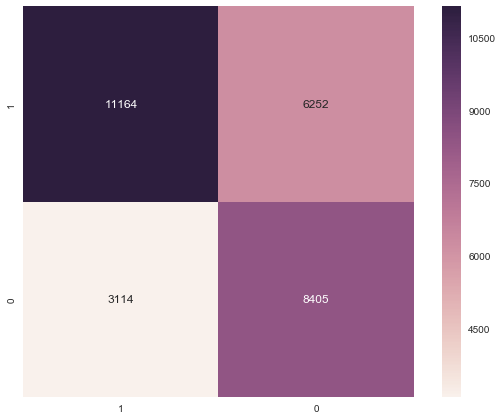

In [131]:
fit_logistic_regression(X, y)

## Model 2: Logistic Regression with Label = activity in last 15 days

In [9]:
drop_cols = ['last_sign_in_at', 
             'created_at', 
             'last_session', 
             'last_favorited_artwork_date', 
             'last_followed_artist_date',
             'total_follows',
             'total_favorites',
             'city']
df = preprocess(drop_cols)

create_label(df, name='engagement15', original_col_name='diff_created_to_last', smaller_than=15)

# Defining y label and X matrix
y = df.pop('engagement15').values
X = df.values

Determining classes statistics... 2 classes detected: Counter({0: 31718, 1: 26109})
Finding the 5 nearest neighbours...
done!
Creating synthetic samples...Generated 5609 new samples ...
done!

Logistic Regression Scores:

Accuracy on test set: 0.739898061058
Precision: 0.698328332619
Recall: 0.850579513418

K-Fold Cross Validation on Logistic Regression Scores:

accuracy: 0.735193020637
precision: 0.674597078614
recall: 0.803656376634

Beta scores:
num_sessions: -0.1998
total_artists_followed: -0.0663
total_artworks_favorited: -0.0147
total_artworks_shared: 0.0989
gender_male: -0.0694
gender_unknown: -0.7463


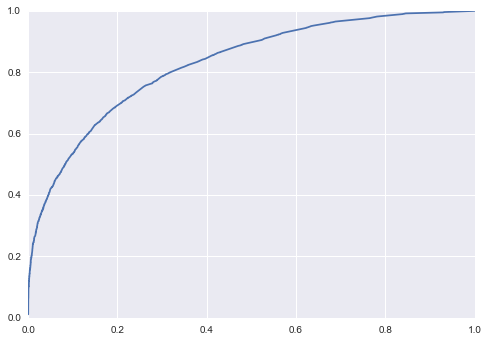


Likelihoods:
*Increasing the num_sessions by 1 point decreases the chance of label=1 by a factor of 0.8240.*

*Increasing the total_artists_followed by 1 point decreases the chance of label=1 by a factor of 0.9649.*

*Increasing the total_artworks_favorited by 1 point decreases the chance of label=1 by a factor of 0.9858.*

*Increasing the total_artworks_shared by 1 point increases the chance of label=1 by a factor of 1.0767.*

*Increasing the gender_male by 1 point decreases the chance of label=1 by a factor of 0.8928.*

*Increasing the gender_unknown by 1 point decreases the chance of label=1 by a factor of 0.5183.*

To double:
*Decreasing the num_sessions score by -3 points doubles the chance of label=1.*

*Decreasing the total_artists_followed score by -10 points doubles the chance of label=1.*

*Decreasing the total_artworks_favorited score by -47 points doubles the chance of label=1.*

*Increasing the total_artworks_shared score by 7 points doubles the chance of label=1.*

*Decr

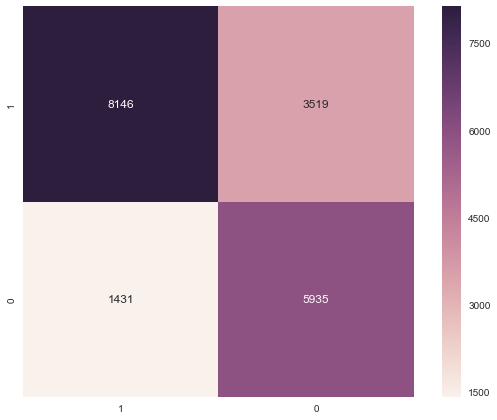

In [10]:
fit_logistic_regression(X, y)

## Model 3: Logistic Regression with Label = activity in last 30 days (ignoring 0 days of activity -> 17k records dropped)

In [17]:
drop_cols = ['last_sign_in_at', 
             'created_at', 
             'last_session', 
             'last_favorited_artwork_date', 
             'last_followed_artist_date',
             'total_follows',
             'total_favorites',
             'city']
df = preprocess(drop_cols)

def negative_to_zero(x):
    if x == -1:
        return 0
    else:
        return x

df.diff_created_to_last = df.diff_created_to_last.apply(lambda x: negative_to_zero(x))

df = df[df.diff_created_to_last > 0]

In [18]:
create_label(df, name='engagement30', original_col_name='diff_created_to_last', smaller_than=30)

# Defining y label and X matrix
y = df.pop('engagement30').values
X = df.values

Determining classes statistics... 2 classes detected: Counter({0: 27443, 1: 13224})
Finding the 5 nearest neighbours...
done!
Creating synthetic samples...Generated 14219 new samples ...
done!

Logistic Regression Scores:

Accuracy on test set: 0.652435321268
Precision: 0.611503531786
Recall: 0.817512877116

K-Fold Cross Validation on Logistic Regression Scores:

accuracy: 0.681066998172
precision: 0.574449831018
recall: 0.129059241002

Beta scores:
num_sessions: -0.0710
total_artists_followed: -0.0315
total_artworks_favorited: -0.0099
total_artworks_shared: 0.0649
gender_male: -0.1417
gender_unknown: -0.4610


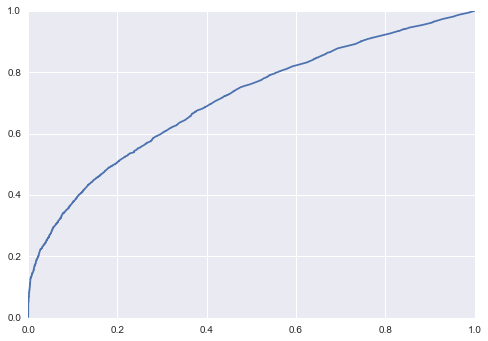


Likelihoods:
*Increasing the num_sessions by 1 point decreases the chance of label=1 by a factor of 0.9317.*

*Increasing the total_artists_followed by 1 point decreases the chance of label=1 by a factor of 0.9892.*

*Increasing the total_artworks_favorited by 1 point decreases the chance of label=1 by a factor of 0.9914.*

*Increasing the total_artworks_shared by 1 point increases the chance of label=1 by a factor of 1.0498.*

*Increasing the gender_male by 1 point decreases the chance of label=1 by a factor of 0.8608.*

*Increasing the gender_unknown by 1 point decreases the chance of label=1 by a factor of 0.6957.*

To double:
*Decreasing the num_sessions score by -9 points doubles the chance of label=1.*

*Decreasing the total_artists_followed score by -21 points doubles the chance of label=1.*

*Decreasing the total_artworks_favorited score by -69 points doubles the chance of label=1.*

*Increasing the total_artworks_shared score by 10 points doubles the chance of label=1.*

*Dec

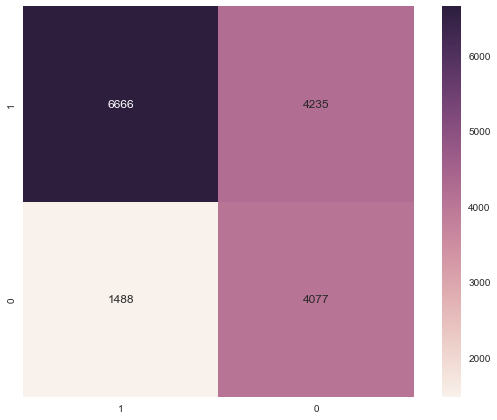

In [19]:
fit_logistic_regression(X, y)

## Model 4: Logistic Regression with Label = purchased

In [547]:
def preprocess_purchases_and_join_with(df):
    # Loading data
    purch = pd.read_csv('purchases.csv', usecols=range(1,5))
    
    # Dropping purchases from anonymous non-registered users
    purch.dropna(inplace=True)
    
    # Aggregating purchase info per user_id
    user_purchs = purch.groupby('user_id').agg({'total_pieces_purchased':np.sum, 'total_spent':np.sum})
    
    # Merging with original DataFrame
    user_merged = df.join(user_purchs)
    
    # Replacing Na's with 0s
    user_merged.total_spent.fillna(0, inplace=True)
    user_merged.total_pieces_purchased.fillna(0, inplace=True)
    
    user_merged.drop('total_pieces_purchased', axis=1, inplace=True)

    user_merged['purchased'] = np.where(user_merged.total_spent > 0, 1, 0)
    
    user_merged.drop('total_spent', axis=1, inplace=True)
    
    return user_merged

In [548]:
drop_cols = ['last_sign_in_at', 
             'created_at', 
             'last_session', 
             'last_favorited_artwork_date', 
             'last_followed_artist_date',
             'total_follows',
             'total_favorites',
             'city']
df = preprocess(drop_cols)

# Dropping date columns due to high relationship and used to create the label:
df.drop('diff_last_fav_artwork_to_today', axis=1, inplace=True)
df.drop('diff_last_artist_folw_to_today', axis=1, inplace=True)
df.drop('diff_created_to_last', axis=1, inplace=True)
df.drop('days_from_last_session', axis=1, inplace=True)

merged_df = preprocess_purchases_and_join_with(df)

### Testing same model with Statsmodel to see how statistically significant the features are:

In [ ]:
sm = SMOTE(kind='regular')
X_resampled, y_resampled = sm.fit_transform(X, y)

# Splitting train and test data
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.3)

X_const = add_constant(X_train, prepend=True)

logit_model = Logit(y_train, X_const).fit()

In [160]:
logit_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                      y   No. Observations:                38406
Model:                          Logit   Df Residuals:                    38399
Method:                           MLE   Df Model:                            6
Date:                Mon, 27 Jun 2016   Pseudo R-squ.:                  0.1131
Time:                        15:03:13   Log-Likelihood:                -23611.
converged:                       True   LL-Null:                       -26621.
                                        LLR p-value:                     0.000
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.9967      0.025     40.486      0.000       0.948       1.045
x1            -0.0729      0.001    -48.924      0.000      -0.076      -0.070
x2            -0.0160      0.005     -3.137      0.002      -0.026      -0.006
x3            -0.0093      0.001    -10.063      0.000      -0.011      -0.007
x4             0.0642      0.013      4.765      0.000       0.038       0.091
x5            -0.1583      0.028     -5.649      0.000      -0.213      -0.103
x6            -0.3460      0.028    -12.257      0.000      -0.401      -0.291
==============================================================================
"""

In [549]:
# Defining y label and X matrix
y = merged_df.pop('purchased').values
X = merged_df.values

Determining classes statistics... 2 classes detected: Counter({0: 55649, 1: 2167})
Finding the 5 nearest neighbours...
done!
Creating synthetic samples...Generated 53482 new samples ...
done!

Logistic Regression Scores:

Accuracy on test set: 0.790296495957
Precision: 0.853191796649
Recall: 0.703944232602

K-Fold Cross Validation on Logistic Regression Scores:

accuracy: 0.961221807112
precision: 0.414696265703
recall: 0.0623382873834

Beta scores:
num_sessions: 0.0049
total_artists_followed: 0.0395
total_artworks_favorited: 0.0046
total_artworks_shared: 0.0286
gender_male: 0.4052
gender_unknown: 0.8201


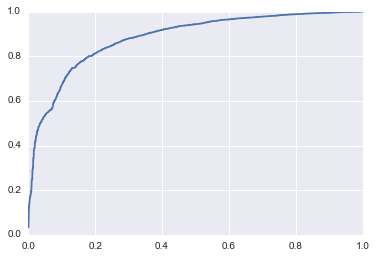


Likelihoods:
*Increasing the num_sessions by 1 point increases the chance of label=1 by a factor of 1.0414.*

*Increasing the total_artists_followed by 1 point increases the chance of label=1 by a factor of 1.1143.*

*Increasing the total_artworks_favorited by 1 point increases the chance of label=1 by a factor of 1.0095.*

*Increasing the total_artworks_shared by 1 point increases the chance of label=1 by a factor of 1.0865.*

*Increasing the gender_male by 1 point increases the chance of label=1 by a factor of 1.4752.*

*Increasing the gender_unknown by 1 point increases the chance of label=1 by a factor of 2.7088.*

To double:
*Increasing the num_sessions score by 142 points doubles the chance of label=1.*

*Increasing the total_artists_followed score by 17 points doubles the chance of label=1.*

*Increasing the total_artworks_favorited score by 149 points doubles the chance of label=1.*

*Increasing the total_artworks_shared score by 24 points doubles the chance of label=1.*

*Inc

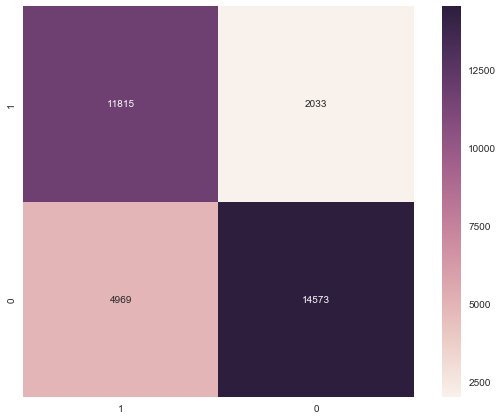

In [550]:
fit_logistic_regression(X, y)

## Confusion matrix notes:

##### We want to minimize False Positives (upper right corner), because if we predict that they will make a purchase and they don't is where we spent the most money/effort without results. 
##### In case of a False Negative (lower left corner), we didn't predict purchase but they bought it anyways, "free" profits $$$

## Model 5: Random Forests with Label = purchased (with best params after GridSearch)

In [767]:
plt.rcParams.update({'font.size': 22})

In [897]:
def fit_random_forest(X, y):
    sm = SMOTE(kind='regular', ratio=0.5)
    X_resampled, y_resampled = sm.fit_transform(X, y)
    
    # Splitting train and test data
    X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.3)
    
    rf = RandomForestClassifier(oob_score=True, n_jobs=-1, bootstrap=True, min_samples_leaf=2, 
                                n_estimators=400, min_samples_split=1, random_state=67, 
                                max_features=None, max_depth=None)
    rf.fit(X_train, y_train)
    
    # Draw a confusion matrix for the results
    y_predict = rf.predict(X_test)
    y_proba = rf.predict_proba(X_test)
    cm = standard_confusion_matrix(y_test, y_predict)
    
    print "Random Forest Scores:\n"
    print "accuracy:", rf.score(X_test, y_test)
    print "precision:", precision_score(y_test, y_predict)
    print "recall:", recall_score(y_test, y_predict)
    
    tpr, fpr, thres = roc_curve(y_proba[:,0:1].flatten(), y_test)
    plt.plot(tpr, fpr)
    plt.title("\nROC Curve\n", fontsize='small')
    plt.xlabel("False Positive Rate (1-Specificity)", fontsize=13)
    plt.ylabel("True Positive Rate (Sensitivity)", fontsize=13)
    plt.savefig('images/roc_curve4.png', bbox_inches='tight', pad_inches=0.5)
    plt.show()
    
    fix, ax = plt.subplots(figsize=(10, 7))
    sns.heatmap(cm, annot=True,  fmt='', square=True, \
                            xticklabels=['1', '0'], \
                            yticklabels=['1', '0']);
    plt.title("\nConfusion Matrix - Random Forests\n", fontsize='small')
    plt.xlabel("Truth", fontsize=13)
    plt.ylabel("Prediction", fontsize=13)
    plt.savefig('images/confusion_matrix4.png', bbox_inches='tight', pad_inches=0.5)
    plt.show()

    cols = list(df.columns)
    
    print "Feature Importance: \n"
    for name, importance in izip(cols, rf.feature_importances_):
        print round(importance,4), '\t\t', name
        
    plot_importance(rf, merged_df, max_features=16)
    plt.savefig('images/rf_feature_importance4.png', bbox_inches='tight', pad_inches=0.5)
    
    return rf

In [898]:
drop_cols = ['last_sign_in_at', 
             'created_at', 
             'last_session', 
             'last_favorited_artwork_date', 
             'last_followed_artist_date',
             'total_follows',
             'total_favorites',
             'city']
df = preprocess(drop_cols)
df = df[~df.index.duplicated(keep='first')]

# Dropping date columns due to high relationship and used to create the label:
df.drop('diff_last_fav_artwork_to_today', axis=1, inplace=True)
df.drop('diff_last_artist_folw_to_today', axis=1, inplace=True)
df.drop('diff_created_to_last', axis=1, inplace=True)
df.drop('days_from_last_session', axis=1, inplace=True)

merged_df = preprocess_purchases_and_join_with(df)
merged_df = merged_df[~merged_df.index.duplicated(keep='first')]

In [899]:
# Scaling features
merged_df.num_sessions = scale(merged_df.num_sessions)
merged_df.total_artists_followed = scale(merged_df.total_artists_followed)
merged_df.total_artworks_favorited = scale(merged_df.total_artworks_favorited)
merged_df.total_artworks_shared = scale(merged_df.total_artworks_shared)

# Defining y label and X matrix
y = merged_df.pop('purchased').values
X = merged_df.values

Determining classes statistics... 2 classes detected: Counter({0: 53167, 1: 2074})
Finding the 5 nearest neighbours...
done!
Creating synthetic samples...Generated 24509 new samples ...
done!
Random Forest Scores:

accuracy: 0.954775339603
precision: 0.94963744232
recall: 0.911426040744


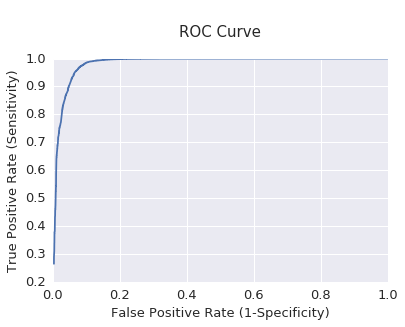

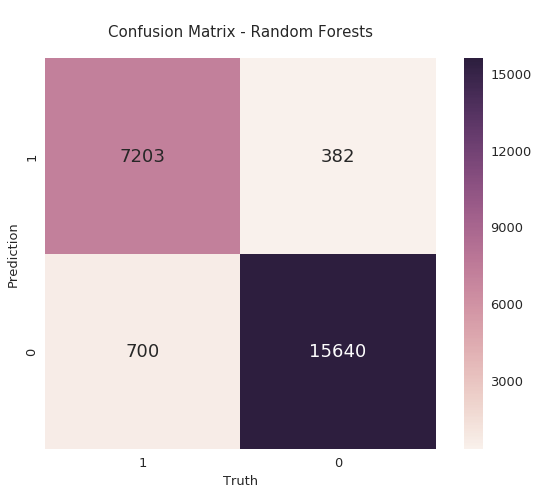

Feature Importance: 

0.7979 		num_sessions
0.0402 		total_artists_followed
0.1298 		total_artworks_favorited
0.0112 		total_artworks_shared
0.0075 		gender_male
0.0134 		gender_unknown


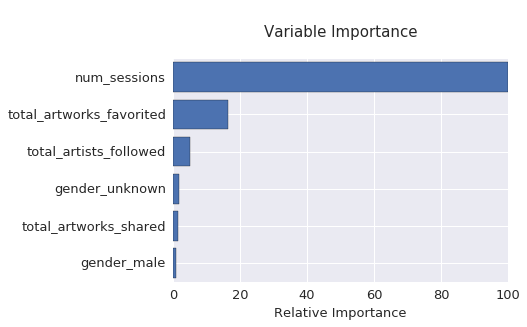

In [900]:
model = fit_random_forest(X, y)

In [742]:
y[3]

1

In [788]:
X[0]

array([ 0.3075905 ,  1.76841926,  0.03038993,  0.56564144,  1.        ,  0.        ])

In [747]:
model.predict_proba(X)

AttributeError: 'numpy.ndarray' object has no attribute 'hist'

Determining classes statistics... 2 classes detected: Counter({0: 55649, 1: 2167})
Finding the 5 nearest neighbours...
done!
Creating synthetic samples...Generated 25657 new samples ...
done!
Random Forest Scores:

accuracy: 0.951122114847
precision: 0.942324317649
recall: 0.909741266245


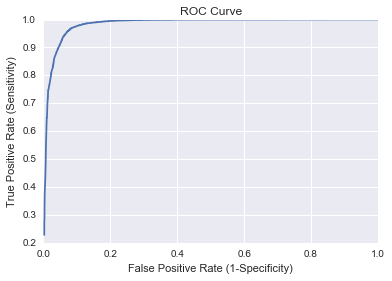

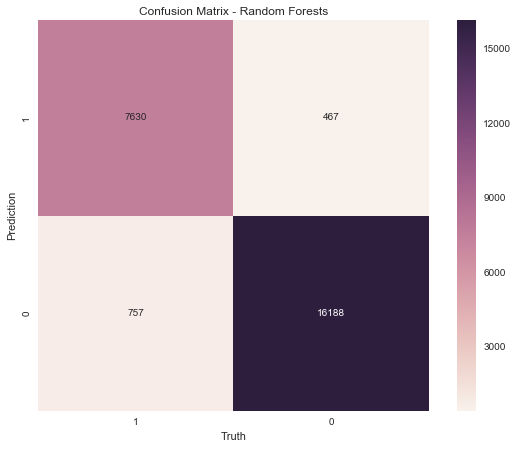

Feature Importance: 

0.7105 		num_sessions
0.0583 		total_artists_followed
0.1803 		total_artworks_favorited
0.0175 		total_artworks_shared
0.0094 		gender_male
0.0239 		gender_unknown


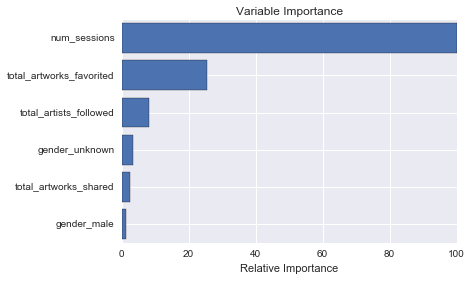

In [754]:
model = fit_random_forest(X, y)

In [517]:
a = np.array([[ 0.18966242,  0.37135351,  0.10676733,  0.56563498,  0.        ,  1.        ], 
             [ 0.1966242,  0.47135351,  0.19676733,  0.06563498,  1.        ,  0.        ],
             [-0.15949266, -0.27305311, -0.23691142, -0.11191526,  0.        , 0.        ]])

In [780]:
model.predict_proba(a)

array([[ 0.0265,  0.9735],
       [ 0.087 ,  0.913 ],
       [ 1.    ,  0.    ]])

In [779]:
[i[1] for i in probs]

[0.97350000000000003, 0.91300000000000026, 0.0]

In [ ]:
# Price distribution (ticket):

In [785]:
X[0]

array([ 0.3075905 ,  1.76841926,  0.03038993,  0.56564144,  1.        ,  0.        ])

In [763]:
probs[0]

array([ 0.81754167,  0.18245833])

In [759]:
type(X)

numpy.ndarray

In [762]:
# Predicting on entire dataset:
probs = model.predict_proba(X)
probss = pd.Series([i[1] for i in probs])
# probs.plot.kde(normalized=True)
probss.quantile(q=0.93)

0.29192688492063557

In [791]:
p = model.predict_proba(X)

In [828]:
matplotlib.rc('xtick', labelsize=13) 
matplotlib.rc('ytick', labelsize=13)

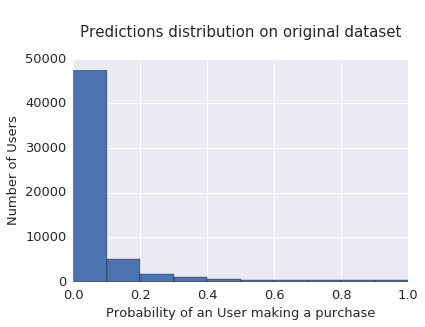

In [860]:
plt.hist([i[1] for i in p])
plt.title("\nPredictions distribution on original dataset\n", fontsize='small')
plt.xlabel("Probability of an User making a purchase", fontsize=13)
plt.ylabel("Number of Users", fontsize=13)
plt.savefig('images/probs_of_purchase2.png', bbox_inches='tight', pad_inches=0.5)

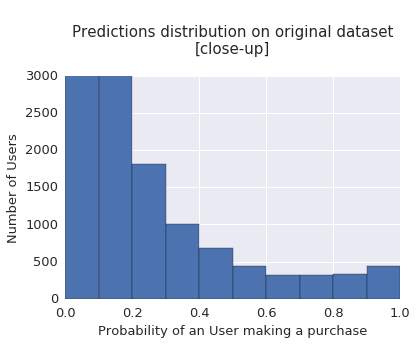

In [859]:
# Zoomed in for better viz:
plt.hist([i[1] for i in p])
plt.ylim(0,3000)
plt.title("\nPredictions distribution on original dataset\n[close-up]\n", fontsize='small')
plt.xlabel("Probability of an User making a purchase", fontsize=13)
plt.ylabel("Number of Users", fontsize=13)
plt.savefig('images/probs_of_purchase_zoom2.png', bbox_inches='tight', pad_inches=0.5)

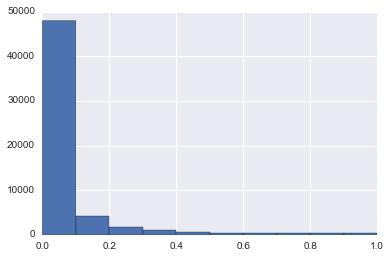

In [790]:
probss.hist()

In [789]:
print "\nTotal registered users:", probss.count()

def recommender(threshold, ticket=267.):
    _1 = probss[(probss>threshold) & (probss<0.95)].count()
    _2 = round(probss[(probss>threshold) & (probss<0.95)].count()/float(probss.count())*100, 1)
    _3 = ticket * _1
    _4 = round(_3 / 1050000. *100, 1)
    
    print "\nTotal registered users with {}-95% purchase probability: {}, or {}% of total users. \nThere will be more costs \
to convert users, but the potential lift considering full conversion would be of ${} - \
or {}% of revenue.".format(int(threshold*100),_1, _2, _3, _4)

for threshold in [0.4, 0.6, 0.8]:
    recommender(threshold)


Total registered users: 57816

Total registered users with 40-95% purchase probability: 2387, or 4.1% of total users. 
There will be more costs to convert users, but the potential lift considering full conversion would be of $637329.0 - or 60.7% of revenue.

Total registered users with 60-95% purchase probability: 1267, or 2.2% of total users. 
There will be more costs to convert users, but the potential lift considering full conversion would be of $338289.0 - or 32.2% of revenue.

Total registered users with 80-95% purchase probability: 532, or 0.9% of total users. 
There will be more costs to convert users, but the potential lift considering full conversion would be of $142044.0 - or 13.5% of revenue.


In [ ]:

'''
Recommendations: 
Focus on users with between 30% and 95% of purchase probability (representing 5-6% of users)

Average ticket of $515; but distribution tell other story:
Average ticket for the biggest chunk (bellow $1,500) is $314

Strategies/scenarios
1) Agressive:
 - Target users with probability of purchase between 30% and 95%
 - 

With a $120 ticket and about 4850 targeted users, potential lift = $378,000 (going from 30% prob until 95% prob)
With the same ticket and about 1450 targeted users, potential lift = $174,000 (going from 50% prob until 95% prob - 
representing 16.5% increase in revenue)
Super conservative (less expenses to convert users): focus on 70-95% probability of purchase
(500+300+300+350+250) * 120

'''


### Trying to fit profit curve

In [533]:
def profit_curve(cost_benefit_matrix, probabilities, y_true):
    thresholds = sorted(probabilities)
    thresholds.append(1.0)
    profits = []
    for threshold in thresholds:
        y_predict = probabilities >= threshold
        confusion_mat = standard_confusion_matrix(y_true, y_predict)
        profit = np.sum(confusion_mat * cost_benefit_matrix) / float(len(y_true))
        profits.append(profit)
    return thresholds, profits


def run_profit_curve(model, costbenefit, X_train, X_test, y_train, y_test):
    model.fit(X_train, y_train)
    probabilities = model.predict_proba(X_test)[:, 1]
    thresholds, profits = profit_curve(costbenefit, probabilities, y_test)
    return thresholds, profits


def plot_profit_models(models, costbenefit, X_train, X_test, y_train, y_test):
    percentages = np.linspace(0, 100, len(y_test) + 1)
    for model in models:
        thresholds, profits = run_profit_curve(model,
                                               costbenefit,
                                               X_train, X_test,
                                               y_train, y_test)
        plt.plot(percentages, profits, label=model.__class__.__name__)
    plt.title("Profit Curves")
    plt.xlabel("Percentage of test instances (decreasing by score)")
    plt.ylabel("Profit")
    plt.legend(loc='upper left')
    plt.savefig('profit_curve.png')
    plt.show()


def find_best_threshold(models, costbenefit, X_train, X_test, y_train, y_test):
    max_model = None
    max_threshold = None
    max_profit = None
    for model in models:
        thresholds, profits = run_profit_curve(model, costbenefit,
                                               X_train, X_test,
                                               y_train, y_test)
        max_index = np.argmax(profits)
        if not max_model or profits[max_index] > max_profit:
            max_model = model.__class__.__name__
            max_threshold = thresholds[max_index]
            max_profit = profits[max_index]
    return max_model, max_threshold, max_profit


def main(X, y):
    sm = SMOTE(kind='regular', ratio=0.5)
    X_resampled, y_resampled = sm.fit_transform(X, y)
    
    # Splitting train and test data
    X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.3)
    
    costbenefit = np.array([[0, 120], [-20, 0]])
    models = [model]
    # plot_profit_models(models, costbenefit,
    #                    X_train, X_test, y_train, y_test)
    plot_profit_models(models, costbenefit, X_train, X_test, y_train, y_test)
    print find_best_threshold(models, costbenefit,
                              X_train, X_test, y_train, y_test)

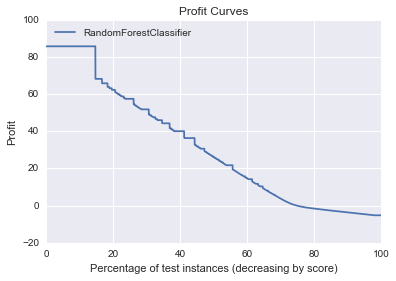

('RandomForestClassifier', 0.0, 85.611603131818768)


In [531]:
main()

In [532]:
drop_cols = ['last_sign_in_at', 
             'created_at', 
             'last_session', 
             'last_favorited_artwork_date', 
             'last_followed_artist_date',
             'total_follows',
             'total_favorites',
             'city']
df = preprocess(drop_cols)

# Dropping date columns due to high relationship and used to create the label:
df.drop('diff_last_fav_artwork_to_today', axis=1, inplace=True)
df.drop('diff_last_artist_folw_to_today', axis=1, inplace=True)
df.drop('diff_created_to_last', axis=1, inplace=True)
df.drop('days_from_last_session', axis=1, inplace=True)

merged_df = preprocess_purchases_and_join_with(df)

# Scaling features
merged_df.num_sessions = scale(merged_df.num_sessions)
merged_df.total_artists_followed = scale(merged_df.total_artists_followed)
merged_df.total_artworks_favorited = scale(merged_df.total_artworks_favorited)
merged_df.total_artworks_shared = scale(merged_df.total_artworks_shared)

# Defining y label and X matrix
y = merged_df.pop('purchased').values
X = merged_df.values

In [ ]:
main(X, y)

## Model 6: Random Forests with Label = activity in last 30 days (ignoring 0 days of activity -> 17k records dropped)

In [155]:
drop_cols = ['last_sign_in_at', 
             'created_at', 
             'last_session', 
             'last_favorited_artwork_date', 
             'last_followed_artist_date',
             'total_follows',
             'total_favorites',
             'city']
df = preprocess(drop_cols)

def negative_to_zero(x):
    if x == -1:
        return 0
    else:
        return x

df.diff_created_to_last = df.diff_created_to_last.apply(lambda x: negative_to_zero(x))

df = df[df.diff_created_to_last > 0]

create_label(df, name='engagement30', original_col_name='diff_created_to_last', smaller_than=30)

# Defining y label and X matrix
y = df.pop('engagement30').values
X = df.values

Determining classes statistics... 2 classes detected: Counter({0: 27433, 1: 13224})
Finding the 5 nearest neighbours...
done!
Creating synthetic samples...Generated 492 new samples ...
done!
Random Forest Scores:

accuracy: 0.675820170109
precision: 0.514166418133
recall: 0.420795704174


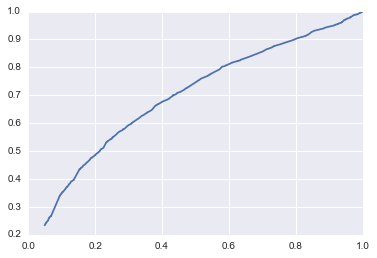

Feature Importance: 

0.466 		num_sessions
0.1449 		total_artists_followed
0.2983 		total_artworks_favorited
0.0457 		total_artworks_shared
0.0187 		gender_male
0.0264 		gender_unknown


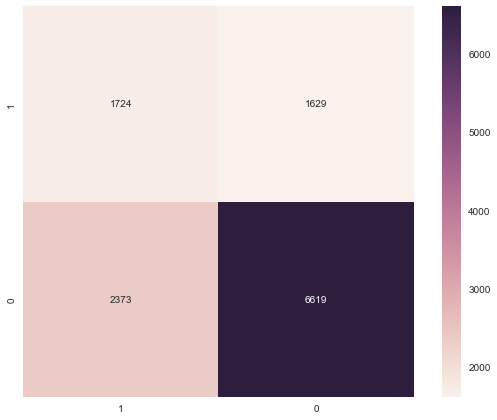

In [156]:
fit_random_forest(X, y)

## Refining models by scaling and grid searching

In [887]:
def plot_importance(clf, X, max_features=10):
    '''Plot feature importance'''
    feature_importance = clf.feature_importances_
    # make importances relative to max importance
    feature_importance = 100.0 * (feature_importance / feature_importance.max())
    sorted_idx = np.argsort(feature_importance)
    pos = np.arange(sorted_idx.shape[0]) + .5
    
    # Show only top features
    pos = pos[-max_features:]
    feature_importance = (feature_importance[sorted_idx])[-max_features:]
    feature_names = (X.columns[sorted_idx])[-max_features:]
    
    plt.barh(pos, feature_importance, align='center')
    plt.yticks(pos, feature_names)
    plt.xlabel('Relative Importance', fontsize=13)
    plt.title('\nVariable Importance\n', fontsize='small')
    

In [199]:
drop_cols = ['last_sign_in_at', 
             'created_at', 
             'last_session', 
             'last_favorited_artwork_date', 
             'last_followed_artist_date',
             'total_follows',
             'total_favorites',
             'city']
df = preprocess(drop_cols)

# Dropping date columns due to high relationship and used to create the label:
df.drop('diff_last_fav_artwork_to_today', axis=1, inplace=True)
df.drop('diff_last_artist_folw_to_today', axis=1, inplace=True)
df.drop('diff_created_to_last', axis=1, inplace=True)
df.drop('days_from_last_session', axis=1, inplace=True)

merged_df = preprocess_purchases_and_join_with(df)

In [200]:
# Defining y label and X matrix
y = merged_df.pop('purchased').values

In [201]:
# Scaling features
merged_df.num_sessions = scale(merged_df.num_sessions)
merged_df.total_artists_followed = scale(merged_df.total_artists_followed)
merged_df.total_artworks_favorited = scale(merged_df.total_artworks_favorited)
merged_df.total_artworks_shared = scale(merged_df.total_artworks_shared)

In [202]:
X = merged_df.values

### Grid Searching Random Forests:

In [203]:
rf_grid = {
    'max_depth': [4, 8, None],
    'max_features': ['sqrt', 'log2', None],
    'min_samples_split': [1, 2, 4],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True], # Mandatory with oob_score=True
    'n_estimators': [50, 100, 200, 400],
    'random_state': [67],
    'oob_score': [True],
    'n_jobs': [-1]
    }

rf_grid_cv = GridSearchCV(RandomForestClassifier(),
                             rf_grid,
                             n_jobs=-1,
                             verbose=True,
                             scoring='roc_auc')

sm = SMOTE(kind='regular', ratio=0.4)
X_resampled, y_resampled = sm.fit_transform(X, y)

# Splitting train and test data
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.3)

rf_grid_cv.fit(X_train, y_train)

print rf_grid_cv.best_params_

best_model = rf_grid_cv.best_estimator_

print "OOB:", best_model.oob_score_

Determining classes statistics... 2 classes detected: Counter({0: 55649, 1: 2168})
Finding the 5 nearest neighbours...
done!
Creating synthetic samples...Generated 20091 new samples ...
done!
Fitting 3 folds for each of 324 candidates, totalling 972 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   53.0s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  4.5min
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed: 12.6min
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed: 27.8min
[Parallel(n_jobs=-1)]: Done 972 out of 972 | elapsed: 38.5min finished


{'oob_score': True, 'n_jobs': -1, 'bootstrap': True, 'min_samples_leaf': 2, 'n_estimators': 400, 'min_samples_split': 1, 'random_state': 67, 'max_features': None, 'max_depth': None}
OOB: 0.954121206565


AttributeError: 'numpy.ndarray' object has no attribute 'columns'

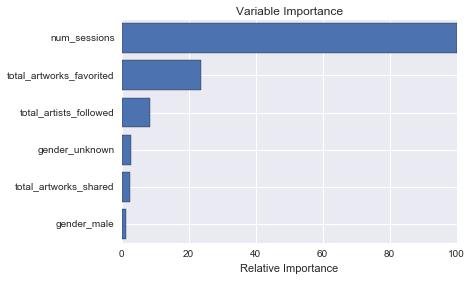

In [222]:
plot_importance(best_model, merged_df, max_features=16)

In [ ]:
42

## Trying to understand puchase cycles:

In [869]:
# Once a user makes a purchase, how long does it take for him to buy again?

pc = pd.read_csv('purchase_cycles.csv')
pc.when = pd.to_datetime(pc['when'])

# Dropping Vango's team ids
vango_ids = [38175, 1, 1326, 587, 736, 45651, 67966, 48516, 84261, 30975, 4260]
for _id in vango_ids:
    pc = pc[pc.id != _id]

pc = pc.sort_values('when', axis=0)
pc['diffs'] = pc.groupby('id').when.diff()
pc['diffs'] = pc.diffs.apply(lambda x: extract_days(x))
pc = pc[pc.diffs != 0]

print "After the first purchase, how many days until purchase #2?", pc.diffs.mean(), "days"

After the first purchase, how many days until purchase #2? 108.612149533 days


In [865]:
pc.median()

Unnamed: 0      955.5
id            47230.0
pieces            1.0
spent           250.0
diffs            48.0
dtype: float64

In [569]:
# Average ticket
pc.total_spent.mean()
515.35*0.20

103.07000000000001

In [687]:
pc[pc.total_spent<1000].total_spent.mean()

266.65559932470455

In [871]:
pc.columns

Index([u'Unnamed: 0', u'id', u'pieces', u'spent', u'when', u'diffs'], dtype='object')

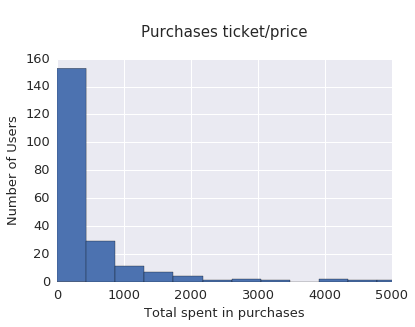

In [875]:
pc.spent.hist(bins=20)
plt.xlim(0,5000)
plt.title("\nPurchases ticket/price\n", fontsize='small')
plt.xlabel("Total spent in purchases", fontsize=13)
plt.ylabel("Number of Users", fontsize=13)
plt.savefig('images/purchases_ticket2.png', bbox_inches='tight', pad_inches=0.5)

In [ ]:
#Compute difference between signup and purchase dates.
#Extract the number days (don't carea bout precise millisecond)
#groupby sum on number of days for num of purchases

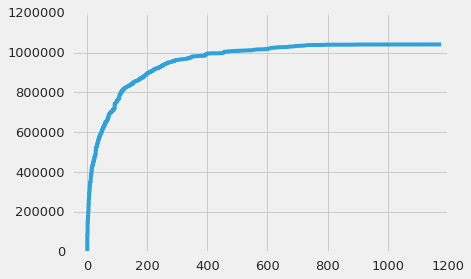

In [877]:
# Loading csv extracted from database into a Pandas DataFrame
df = pd.read_csv('dataset.csv', usecols=range(1,17))

# Treating date fields and converting them to datetime timestamp
df['acc_created_at'] = pd.to_datetime(df['created_at'])
df.drop('created_at', axis=1, inplace=True)
df.last_session = pd.to_datetime(df['last_session'])
df.last_favorited_artwork_date = pd.to_datetime(df['last_favorited_artwork_date'])
df.last_followed_artist_date = pd.to_datetime(df['last_followed_artist_date'])

# Creating function to extract only the days (int) from TimeDelta objects
def extract_days(x):
    try:
        return x.days
    except:
        return 0

def negative_to_zero(x):
    if x < 0:
        return 0
    else:
        return x    

df = df.set_index('id')

# Loading data
purch = pd.read_csv('purchases.csv', usecols=range(1,5))

# Dropping Vango's team ids
vango_ids = [38175, 1, 1326, 587, 736, 45651, 67966, 48516, 84261, 30975, 4260]
for _id in vango_ids:
    purch = purch[purch.user_id != _id]

purch = purch.set_index('user_id')

# Dropping purchases from anonymous non-registered users
purch.dropna(inplace=True)

pc = df.join(purch)

pc.created_at = pd.to_datetime(pc['created_at'])

# New feature: Extracting the difference between last session and today
pc['diff_acc_to_purchase'] = pc.created_at - pc.acc_created_at
pc['diff_acc_to_purchase'] = pc.diff_acc_to_purchase.apply(lambda x: extract_days(x))
pc['diff_acc_to_purchase'] = pc.diff_acc_to_purchase.apply(lambda x: negative_to_zero(x))

pc = pc[pc.diff_acc_to_purchase != 0]


pc = pc.sort_values('diff_acc_to_purchase')

with plt.style.context('fivethirtyeight'):
    plt.plot(pc.diff_acc_to_purchase, np.cumsum(pc.total_spent))
    plt.xlim(-50)

In [559]:
pc.diff_acc_to_purchase.mean()

112.32029702970297

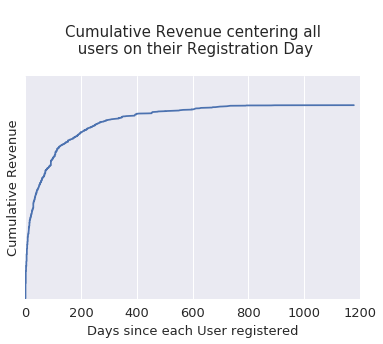

In [879]:
plt.plot(pc.diff_acc_to_purchase, np.cumsum(pc.total_spent))
plt.title("\nCumulative Revenue centering all\n users on their Registration Day\n", fontsize='small')
plt.yticks([])
plt.xlabel("Days since each User registered", fontsize=13)
plt.ylabel("Cumulative Revenue", fontsize=13)
plt.savefig('images/cumulative_revenue_from_registrations2.png', bbox_inches='tight', pad_inches=0.5)

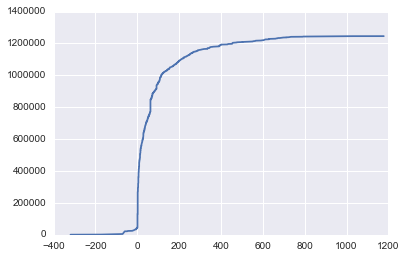

In [298]:
plt.plot(pc.diff_acc_to_purchase, np.cumsum(pc.total_spent))

In [299]:
pc.diff_acc_to_purchase.mean()

112.99273255813954

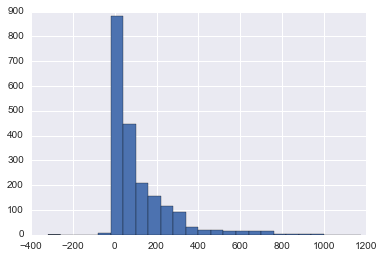

In [301]:
pc.diff_acc_to_purchase.hist(bins=25)

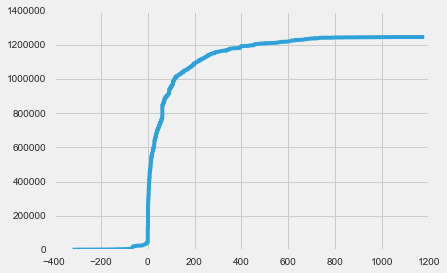

In [302]:
with plt.style.context('fivethirtyeight'):
    plt.plot(pc.diff_acc_to_purchase, np.cumsum(pc.total_spent))

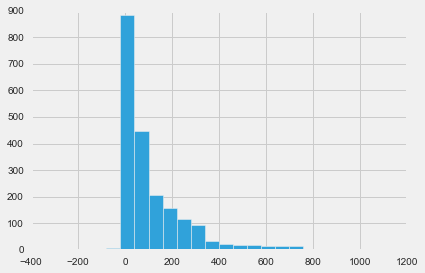

In [305]:
with plt.style.context('fivethirtyeight'):
    pc.diff_acc_to_purchase.hist(bins=25)

In [335]:
tmp = pc[['diff_acc_to_purchase', 'total_spent']]

In [341]:
def negative_to_zero(x):
    if x < 0:
        return 0
    else:
        return x

In [342]:
tmp.diff_acc_to_purchase = tmp.diff_acc_to_purchase.apply(lambda x: negative_to_zero(x))

In [366]:
tmp = tmp.groupby(tmp.index).agg({'diff_acc_to_purchase': np.min})
print "Average time since registration for an user to make the first purchase:", tmp.diff_acc_to_purchase.mean(), "days"

Average time since registration for an user to make the first purchase: 103.324216524 days


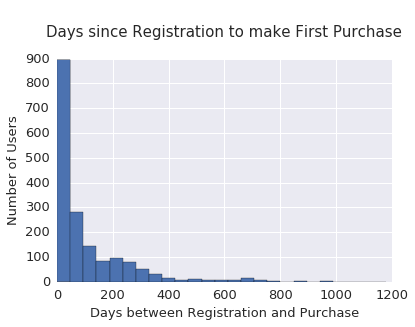

In [883]:
tmp.diff_acc_to_purchase.hist(bins=25)
plt.title("\nDays since Registration to make First Purchase\n", fontsize='small')
plt.xlabel("Days between Registration and Purchase", fontsize=13)
plt.ylabel("Number of Users", fontsize=13)
plt.savefig('images/days_from_reg_to_purch2.png', bbox_inches='tight', pad_inches=0.5)

In [772]:
df[df.num_sessions > 200]

,num_sessions,total_artists_followed,total_artworks_favorited,total_artworks_shared,gender_male,gender_unknown
id,,,,,,
11680.0,224.0,9.0,94.0,3.0,0.0,1.0
1198.0,462.0,7.0,99.0,2.0,0.0,1.0
12879.0,207.0,51.0,98.0,0.0,0.0,1.0
14105.0,266.0,8.0,96.0,0.0,1.0,0.0
14184.0,821.0,1.0,9.0,0.0,0.0,1.0
15149.0,538.0,16.0,34.0,9.0,0.0,1.0
15608.0,653.0,136.0,203.0,0.0,0.0,1.0
15993.0,471.0,8.0,190.0,9.0,1.0,0.0
16963.0,533.0,0.0,99.0,0.0,0.0,1.0
